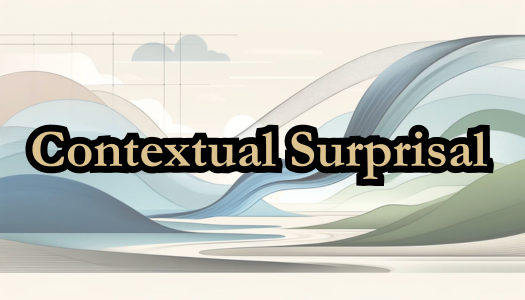

# Text segmentation with contextual surprisal


This is a novel text segmentation algorithm that takes an information-theoretic approach. It uses a concept known as **surprisal** (or self-information). This was written by Afrizal Hasbi Azizy (me), who took inspiration from my readings in cognitive science. It's a prototype algorithm with much work to do, but it works quite well during initial testing. Enjoy!


You can find me at: https://www.linkedin.com/in/afrizal-hasbi-azizy-182722218/

(p.s. the name 'contextual' surprisal is a bit misleading, but it's the nicest-sounding placeholder name I can think of for now)


Before we start, let's define some preliminary functions: one to clean a string and one to get a dictionary of word frequency.

In [ ]:
### Define the functions
import math

# Define a function to clean the text
def clean_text(text, withdots=True):
    text = text.lower()
    allowed = "- "
    if withdots:
        allowed +='.'
    return ''.join(char for char in text if char.isalnum() or char in allowed)

# Get a dictionary of word frequency
def wordfreq(text: str):
    freq = {}
    text = clean_text(text, withdots=False)
    text = text.split()
    for word in text:
        word = str(word).lower()
        if word not in freq:
            freq[word] = 1
        else:
            freq[word] +=1
    return freq

## Intro to surprisal

Surprisal is a measure in information theory that describes "unexpectedness". It quantifies the amount of information conveyed by an occurrence of an event using negative log probabilities, with less probable events having higher surprisal (e.g., more "surprising").


Assume that a well-organized text can be broken down into multiple sections, each section describing unique things. The intuitive idea behind this algorithm is that the start of a new segment contains information which are new relative to both the preceding and succeeding tokens.


Let $w_i$ be a token of information in a sequence of tokens $W = (w_1, \ldots, w_n)$, which in our case can be a word or a sentence, and $p(w_i)$ is the probability of $w$ occurring in the string, which is the frequency of $w$ divided by the total number of tokens. The surprisal $I$ of $w$ can be computed as:

\begin{align*}\\
I(w_i) &= -\log_2 \ p(w_i) \in W \
\end{align*} \\


To compute the surprisal of a sequence of tokens $I_S$, we simply sum the surprisal of each individual tokens. The surprisal of a sequence $S$ of $n$ tokens can then be formulated as:

\begin{align*}\\
I_S &= \sum_{w=1}^{n} I(w)
\end{align*} \\

In [ ]:
# Word-level surprisal
def surprisal(word: str, freq: dict, totcount=None):
    if totcount is None:
        totcount = sum(freq.values())
    word = word.lower()
    word = clean_text(word, withdots=False)
    surprisal = 0

    if word not in freq:
        surprisal += float('inf')
    else:
        prob = freq[word] / totcount
        surprisal += -math.log2(prob)
    return surprisal

# Sentence-level surprisal
def surprisalSent(sentence: str, freq:dict, totcount=None):
    if totcount is None:
        totcount = sum(freq.values())
    sentence = clean_text(sentence)
    sentence = sentence.split()
    sentence_surprisal = 0
    if totcount is None: totcount = sum(freq.values())
    for words in sentence:
        sentence_surprisal += surprisal(words, freq, totcount)
    return sentence_surprisal

You can test it out on a small-scale, below. If you run the code, you will find that 'fish' has a higher surprisal compared to 'i'. You can think of 'fish' as more "surprising" compared to 'i' because it occurs fewer times in the entire text.

On the other hand, 'nose' will have a surprisal value of infinity. This is because 'nose' does not occur at all in the text, thus making it infinitely surprising.


In [ ]:
TEXT = "I am human. He is not human. He is fish. I am not.".lower()
FREQ = wordfreq(TEXT)
for k,v in FREQ.items(): print(k,':',v)

i_surprisal = surprisal('i', FREQ)
fish_surprisal = surprisal('fish', FREQ)
nose_surprisal = surprisal('nose', FREQ)

print(f'''Surprisal for "i": {i_surprisal}''')
print(f'''Surprisal for "fish": {fish_surprisal}''')
print(f'''Surprisal for "nose": {nose_surprisal}''')

i : 2
am : 2
human : 2
he : 2
is : 2
not : 2
fish : 1
Surprisal for "i": 2.700439718141092
Surprisal for "fish": 3.700439718141092
Surprisal for "nose": inf


Below is another short code to test the surprisal of a word sequence, which you can think of as a sentence. You'll see that the phrase 'very much' has higher surprisal compared to 'a little'. This is because we have two occurrences of 'a little', but just one occurrence of 'very much'. (**NOTE: This algorithm does not account for word positions**).

Similar to the above, the phrase 'he hates her' is infinitely surprising because it does not appear at all in the text.

In [ ]:
TEXT = "I love you very much. I love you a little. He hates me a little bit. He hates me.".lower()
FREQ = wordfreq(TEXT)
for k,v in FREQ.items(): print(k,':',v)

alittle_surprisal = surprisalSent('a little', FREQ)
verymuch_surprisal = surprisalSent('very much', FREQ)
hehatesher_surprisal = surprisalSent('he hates her', FREQ)

print(f'''Surprisal for "a little": {alittle_surprisal}''')
print(f'''Surprisal for "a little bit": {verymuch_surprisal}''')
print(f'''Surprisal for "he hates her": {hehatesher_surprisal}''')

i : 2
love : 2
you : 2
very : 1
much : 1
a : 2
little : 2
he : 2
hates : 2
me : 2
bit : 1
Surprisal for "a little": 6.495855026887171
Surprisal for "a little bit": 8.49585502688717
Surprisal for "he hates her": inf


## The algorithm

Having able to compute the surprisal of a sequence of tokens, we can now begin woking on text segmentation. To designate which sentence acts as the start or end of a new segment, we need to compute a segmentation score for every token in the sequence. Let $w_i$ be a token in a sequence of tokens $W = (w_1, \ldots, w_n)$. We define the preceding context of $w_i$ to be $W_{1i} = (w_1, \ldots, w_i)$, and the succeeding context of $w_i$ to be $W_{2i} = (w_i, \ldots, w_n)$.
We first need to compute the surprisal values of $W_{1i}$ and $W_{2i}$ using the above equation:


\begin{equation*}
\begin{aligned}\\
I_1(w_i) &= \sum_{w=1}^{i} I(w), \qquad I_2(w_i) = \sum_{w=i}^{n} I(w)
\end{aligned}
\end{equation*} \\


\begin{equation*}
\begin{aligned}\\
I_1(w_i) &= I(W_{1i}), \qquad I_2(w_i) = I(W_{2i})
\end{aligned}
\end{equation*} \\


Let's take the example paragraph from the previous code block. Suppose we want to compute the segmentation score of the second sentence, $w_2 = \text{He hates me a little bit}$. We can compute $I_1$ and $I_2$ like so:


\begin{align}\\
I_1(w_2) &= I(\text{I love you very much. I love you a little.}) \\
I_2(w_2) &= I(\text{I love you a little. He hates me a little bit. He hates me.})
\end{align} \\


But how do we use these values to segment a text? As mentioned, the intuition in this algorithm is that a single token in a sequence is informative in the context of all the tokens before it (below, left) and  all the tokens after it (below, right):


\begin{align}\\
\frac{I_1(w_i)}{I_2(w_i) + 1}, \quad \frac{I_2(w_i)}{I_1(w_i) + 1}
\end{align} \\


We can now compute the segmentation score for the token $w$ as the product of the token surprisal in the context of the all the tokens before and after it:


\begin{align}\\
S(w_i) &= \frac{I_1(w_i) \times I_2(w_i)}{(I_2(w_i)+1) \times (I_1(w_i)+1)}
\end{align} \\


Once we compute the $S$ for all $w$, we can designate the top $k$ tokens with the highest $S$ as the separator between sections, with the full algorithm summarized like so:


\begin{align}\\ \text {top k} \ S(w), w \in (w_1, \ldots, w_n), w \neq w_1 \text{ and } w \neq w_n\end{align} \\


We ignore the first and last tokens as we consider them invalid segment separators. In the implementation we assign them the values negative infinity to ensure them always ranked the last.

In [ ]:
# Function to segment the text
def segment(text:str, k:int, segloc='none'):
    if segloc not in ['start','end', 'none']:
        raise ValueError('''"segloc" argument must be "start", "end", or "none"''')
    text = clean_text(text)
    text = text.split('.')
    sentences = [s for s in text if s!='']
    idxRank = []

    # Compute the segmentation score for each sentence
    for idx, t in enumerate(sentences):
        t = t.strip()
        if idx == 0:
            idxRank.append((idx,t,float('-inf')))
        elif idx == len(sentences)-1:
            idxRank.append((idx,t,float('-inf')))
        else:
            FIRST = ''.join(str(s) for s in sentences[:idx+1]).strip()
            FIRSTFREQ = wordfreq(FIRST)
            INFO_ONE = surprisalSent(t, FIRSTFREQ)

            SECOND = ''.join(s for s in sentences[idx:]).strip()
            SECONDFREQ = wordfreq(SECOND)
            INFO_TWO = surprisalSent(t, SECONDFREQ)

            SCORE = (INFO_ONE /(INFO_TWO+1)) * (INFO_TWO /(INFO_ONE+1))
            idxRank.append((idx, t, SCORE))

    # Retrieve the top k sentences
    idxRank.sort(key=lambda x: x[2], reverse=True)
    separator = [x[1] for x in idxRank[:k]]
    top_k_idx = [x[0] for x in idxRank[:k]]
    top_k_idx.sort()
    idxRank.sort(key=lambda x: x[0])

    # Separate sections
    start = 0
    sections = []
    for idx in top_k_idx:
        if idx != top_k_idx[-1]:
            sections.append(' '.join(s.strip() + '.' for s in sentences[start:idx]))
        else:
            sections.append(' '.join(s.strip() + '.' for s in sentences[idx:]))
        start = idx

    # Display sections
    print('SECTIONS')
    for idx,s in enumerate(sections):
      print(f'{idx+1}: {s}')
    print('\n')

    # Display individual sentences
    if segloc != 'none': print('SECTION 1')
    i = 2
    for s in idxRank:
        idx = s[0]
        t = s[1]
        surprisal = s[2]
        if t in separator:
            if segloc=='start':
                print(f'\nSECTION {abs(k-(k-i))}')
                i +=1
            t = '\033[32m'+t+'.'+'\033[0m'.strip()
            print(f'{idx}: ({surprisal:.6f}) {t}')
            if segloc=='end':
                print(f'\nSECTION {abs(k-(k-i))}')
                i +=1
        else:
            t = t+'.'.strip()
            print(f'{idx}: ({surprisal:.6f}) {t}')

In its current form, the algorithm is designed to work with a string consisting of multiple sentences (period-separated). From current testing, the algorithm works best for long texts.

Below is an example where we segment a blog from Microsoft's website. Download the file from Dropbox and test out with different parameters. Have fun!

Example source: https://news.microsoft.com/source/features/ai/the-phi-3-small-language-models-with-big-potential/

In [ ]:
### Download and open an example text from dropbox
!wget -q -O 'example_microsoft.txt' 'https://www.dropbox.com/scl/fi/ykmw3ywlcuv872ps876zc/example_microsoft.txt?rlkey=hjo747f2lpoeeg8p548gfhu0d&st=zto1z4hb&dl=0'
with open("example_microsoft.txt", "r", encoding='utf-8') as file:
    example_microsoft = file.read()

## Segment the blog.
## NOTE: The segmentation is indicated by color-printing. Please use dark mode for better visibility.
segment(text=example_microsoft,
        k=7,
        segloc='start')

SECTIONS
1: sometimes the best way to solve a complex problem is to take a page from a childrens book. thats the lesson microsoft researchers learned by figuring out how to pack more punch into a much smaller package.
2: last year after spending his workday thinking through potential solutions to machine learning riddles microsofts ronen eldan was reading bedtime stories to his daughter when he thought to himself how did she learn this word how does she know how to connect these words  that led the microsoft research machine learning expert to wonder how much an ai model could learn using only words a 4-year-old could understand  and ultimately to an innovative training approach thats produced a new class of more capable small language models that promises to make ai more accessible to more people. large language models llms have created exciting new opportunities to be more productive and creative using ai. but their size means they can require significant computing resources to opera